<a href="https://colab.research.google.com/github/Entro01/ML-starter/blob/main/makemore/makemore_MLP/makrmore_MLP_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [8]:
# building the vocabulary of characters

chrs = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [33]:
# building the dataset

block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [34]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # no. of neurons in the hiddlen layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator = g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator = g)
B1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn(n_hidden, vocab_size, generator = g)
B2 = torch.randn(vocab_size, generator = g)

parameters= [C, W1, B1, W2, B2]
print(sum(p.nelement() for p in parameters)) # total parameters

for p in parameters:
  p.requires_grad = True

11897


In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creating a mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y (batch_size, block_size), (batch_size)

  # forward pass
  emb = C[Xb] # embed the characters into vectors (batch_size, n_embd, block_size)
  embcat = emb.view(emb.shape[0], block_size * n_embd) # concatenating vectors (batch_size, n_embd * block_size)
  hpreact = embcat @ W1 + B1 # hidden layer pre-activation (batch_size, n_hidden)
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + B2 # output layer (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

print("loss: ", loss.item())

      0/ 200000: 27.5998
  10000/ 200000: 2.8792
  20000/ 200000: 2.3820
  30000/ 200000: 2.3063
  40000/ 200000: 2.4857
  50000/ 200000: 2.1121
  60000/ 200000: 2.1005
  70000/ 200000: 2.1712
  80000/ 200000: 1.9520
  90000/ 200000: 2.0515
 100000/ 200000: 2.1969
 110000/ 200000: 2.0604
 120000/ 200000: 2.1624
 130000/ 200000: 2.4148
 140000/ 200000: 2.0665
 150000/ 200000: 2.2149
 160000/ 200000: 2.0580
 170000/ 200000: 2.0960
 180000/ 200000: 1.9545
 190000/ 200000: 2.0411
loss:  1.8538776636123657


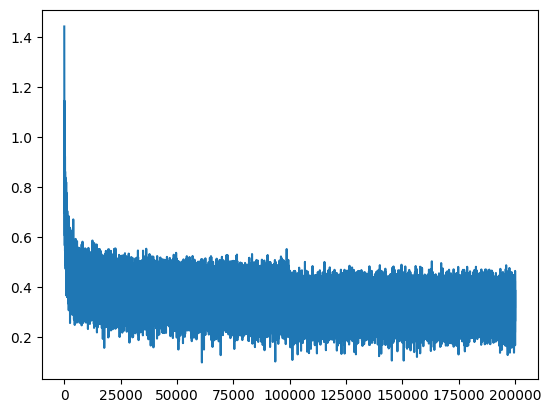

In [36]:
plt.plot(lossi)

In [37]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], block_size * n_embd) # concatinating vectors
  hpreact = embcat @ W1 + B1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + B2 # output layer
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1270627975463867
val 2.1598734855651855


We notice that there is a high initialization loss, i.e. the logits are badly initialized the first time around. Since at the first run, we expect our neural network to be completely unbiased, we expect the logits to be uniformly distributed. This results in a uniform probability distribution, which in turn results in a moderade loss.

This is what we expect our logits to look like at initialization:

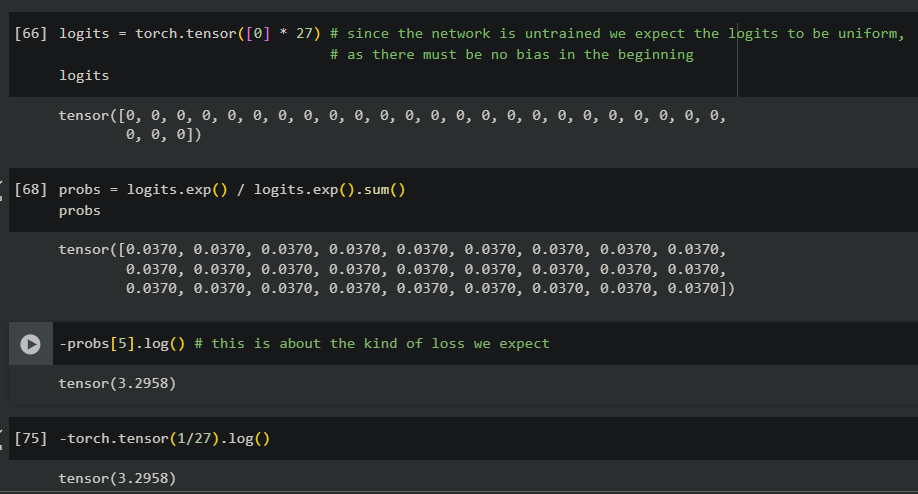

We could have gotten the same result with a number other than 0 if all the logits are uniform but by symmetry we dont want them to be a negative or positive number, we want them to be closer to zero.

This is what the logits at initialization look like rn:

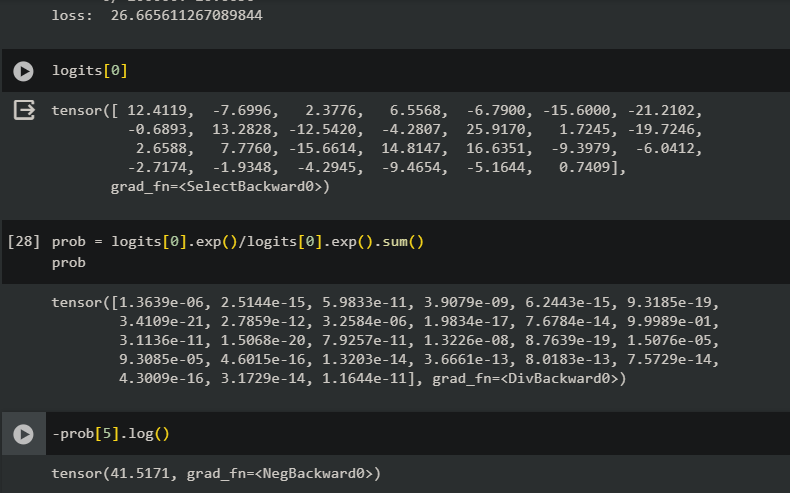

In [38]:
# fixing the initial loss
# we will now initialize the bias of our output layer as zero and the weigts as close to zero

n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # no. of neurons in the hiddlen layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator = g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator = g)
B1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn(n_hidden, vocab_size, generator = g) * 0.001
B2 = torch.randn(vocab_size, generator = g) * 0

parameters= [C, W1, B1, W2, B2]
print(sum(p.nelement() for p in parameters)) # total parameters

for p in parameters:
  p.requires_grad = True

11897


In [39]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creating a mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y (batch_size, block_size), (batch_size)

  # forward pass
  emb = C[Xb] # embed the characters into vectors (batch_size, n_embd, block_size)
  embcat = emb.view(emb.shape[0], block_size * n_embd) # concatenating vectors (batch_size, n_embd * block_size)
  hpreact = embcat @ W1 + B1 # hidden layer pre-activation (batch_size, n_hidden)
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + B2 # output layer (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

print("loss: ", loss.item())

      0/ 200000: 3.2991
  10000/ 200000: 2.3559
  20000/ 200000: 2.2930
  30000/ 200000: 2.0451
  40000/ 200000: 2.3584
  50000/ 200000: 2.1221
  60000/ 200000: 2.2102
  70000/ 200000: 1.9967
  80000/ 200000: 2.0739
  90000/ 200000: 2.0431
 100000/ 200000: 2.3796
 110000/ 200000: 2.1520
 120000/ 200000: 1.9499
 130000/ 200000: 2.3294
 140000/ 200000: 1.9947
 150000/ 200000: 2.1474
 160000/ 200000: 1.9973
 170000/ 200000: 2.0789
 180000/ 200000: 1.9862
 190000/ 200000: 2.0581
loss:  1.6299617290496826


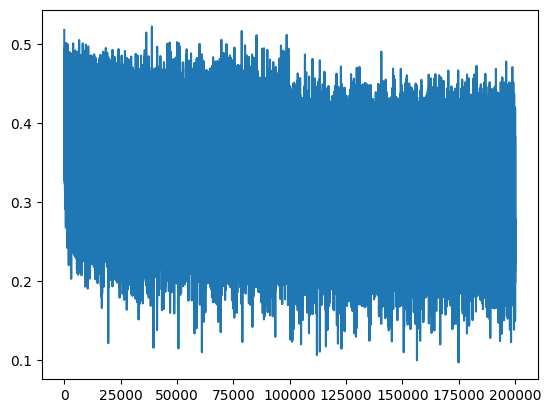

In [40]:
plt.plot(lossi)

In [ ]:
# initial loss fixed